Camille Balo
Project 4

**INTRODUCTION**

Description/Summary: This project aims to web scrape for various businesses following the specified keyword. Upon finding the businesses, reviews and ratings will then be scraped and analyzed for further understanding, including sentiment analysis using both the default textblob sentiment analyzer and the naive bayes sentiment analyzer. The results of the sentiment analzyer will then be used to create various informative graphs showing the positivity/negativity and subjectivity/objectivity of the reviews. 

import all required modules

In [112]:
import requests
import json
from textblob import TextBlob as tb
import nltk
from nltk.corpus import stopwords
from textblob.sentiments import NaiveBayesAnalyzer as na
import matplotlib.pyplot as plt

create variables to hold the API key generated when creating the app through the Yelp Dev website

In [2]:
api_key = 'i3DsWXHAqAdylaOb_R1NFEsmrN3o8TKnFf5JzsOjyWspNEgtxkZINq4Y3jm8zjATyGWI1k14a7BiN8eTHiYyRf_fV61gHh0c9HdWOc5EbdYVuaiPgECM1Q5cCMdTZHYx'
headers = {'Authorization': 'Bearer %s' % api_key}

define the url and parameters for the business search

In [3]:
url='https://api.yelp.com/v3/businesses/search'

#in this case, bakeries in NJ will be what is searched
params = {'term':'bakery','location':'New Jersey'}

send a get request and print the values in the JSON object (if the GET is successful)

In [5]:
#send a GET request
response = requests.get(url, params=params, headers=headers)
#get the HTTP status code 
status = response.status_code
#if the status is 200 (successful) print the value of the JSON
if status == 200:
    businesses_json = json.loads(response.text)
else:
    print(f"Error. Status code {status}.")

print the following information from the JSON object: name of business and id of business--the id will later be used to go to the reviews page of that business

In [21]:
#use a try/except statement to handle any exceptions that are thrown
try:
    top_businesses = []
    for val in businesses_json.values():
        #iterate over each business entry--enumerate the dictionary values to get both the key and value
        for key, business_val in enumerate(val):
            #only going to get the first 10 businesses just for simplicity 
            if key >= 10:
                break
            #get the name, id, and review count
            bus_id = business_val['id']
            bus_name = business_val['name']
            bus_review_count = business_val['review_count']
            #temp business list to format the list
            business_add = [bus_name, bus_id, bus_review_count]
            #append to top business list
            top_businesses.append(business_add)
            #print the values in a list format (to make it neater and easier to read)
            print(business_add)
#this except statement will handle the type error that usually occurs when iterating over the values
except TypeError:
    pass
#catch all other exceptions
except Exception as e:
    print(e)

["Teixeira's Bakery", 'WDO572T_K4e2XFljjpQfkA', 283]
['Soul Sweet Boutique', 'NirktWbEh_ytqDDHqRbrzA', 32]
['Pao Da Terra Bakery', 'Ns9nsB1-KUnUhHvvWDye1Q', 54]
['Elan Cafe + Bubbleology', 'RhXV45QAuIpABSNM5vKxPw', 4]
["Calandra's Italian & French Bakery", 'ON1Uv0nm7CVvOBWxhbA9pg', 194]
["Tonnie's Minis", 'N07dN8PSMwvh1l681cJlvQ', 34]
['Gio Docinhos', '1OPVyccr0TWo0hIzs7daDQ', 14]
['The Bread Stand', 'TTUjOo7AtHzWWHhvYgt8Tw', 119]
['Level One Bakery', 'L6o6epAGG8oFLXy_ZP2bcA', 6]
['Mattarello Bakery & Cafe', 'QLjvHXqv0I70iiP3DIdpcA', 42]


as shown from the output of the first 10 bakeries, we get the Name, ID, and how many reivews there are for that bakery. the ID will be important later for getting the reviews of each bakery. i also included the review count to be displayed since i would rather not analyze a bakery with less than 10 reviews as it wouldn't provide enough information compared to some of the other bakeries that have more reviews than that.

remove the bakery from the list if it has 10 reviews or less--after running the code, we are left with 8 bakeries

In [23]:
#iterate over the top_businesses list
for i, val in enumerate(top_businesses):
    if val[2] <= 10:
        #remove the entire value at the index that contains 10 or less reviews
        top_businesses.pop(i)
#iterate over teh list to print neater
for val in top_businesses:
    print(val)


["Teixeira's Bakery", 'WDO572T_K4e2XFljjpQfkA', 283]
['Soul Sweet Boutique', 'NirktWbEh_ytqDDHqRbrzA', 32]
['Pao Da Terra Bakery', 'Ns9nsB1-KUnUhHvvWDye1Q', 54]
["Calandra's Italian & French Bakery", 'ON1Uv0nm7CVvOBWxhbA9pg', 194]
["Tonnie's Minis", 'N07dN8PSMwvh1l681cJlvQ', 34]
['Gio Docinhos', '1OPVyccr0TWo0hIzs7daDQ', 14]
['The Bread Stand', 'TTUjOo7AtHzWWHhvYgt8Tw', 119]
['Mattarello Bakery & Cafe', 'QLjvHXqv0I70iiP3DIdpcA', 42]


get the reviews and ratings of each bakery

In [55]:
#create a new dict that will hold all of the reviews for all of the businesses and the ratings for each business
business_reviews = {}
business_ratings = {}

#iterate over the business list
for val in top_businesses:
    #set the variable to index 1 since that is where the id is in each list
    id = val[1]
    #create the url to send a GET request to 
    url="https://api.yelp.com/v3/businesses/" + id + "/reviews"
    #send the get req
    req = requests.get(url, headers=headers)
    #get the text
    parsed = json.loads(req.text)
    #get the reviews specifically
    reviews = parsed["reviews"]

    #create an empty list to hold the reviews we iterate over later
    temp_rev = []
    #iterate over the reviews
    for review in reviews:
        #append only the value at the 'text' key to the temp list
        temp_rev.append(review['text'])
    
    #add the review list and business name to the dictionary
    business_reviews[val[0]] = temp_rev

    #create an empty list to hold the ratings we iterate over later
    temp_rat = []
    #iterate over the reviews
    for review in reviews:
        #append only the value at the 'rating' key to the temp list
        temp_rat.append(review['rating'])

    #add the review list and business name to the dictionary
    business_ratings[val[0]] = temp_rat

#print both dicts
print(business_reviews)
print(business_ratings)


{"Teixeira's Bakery": ['I saw the great reviews on the pastelitos de nata and stopped by during my trip. Parking is difficult to find. I parked a few blocks away. The bakery is on...', "One of my favorite morning haunts in New York City area - although technically it's in New Jersey, and past the lifeless Jersey City (at least in the...", "First off I wanna start by saying, in the Ironbound there is no better bakery. \n\nEvery time I come into the bakery it feels like I'm walking into a little..."], 'Soul Sweet Boutique': ["This  place it's amazing place in Newark. The best breakfast ever and service is very pleasant.", 'Nope.....!\n\nWe saw their Luxury Truffle Collection offered on QVC. The truffles presented there were presented as large enough to be cut in half and shared...', "This place is awful. I'm not sure what the hype is all about. Service when we picked up cake and sweets was rude. The brigadeiros don't taste like the..."], 'Pao Da Terra Bakery': ['After having dinner in Ne

clean the reviews:
    -remove all '\n'
    -remove '...'

In [70]:
#create a new dictionary to hold the cleaned reviews
cleaned_reviews = {}

#iterate over the reviews dict, getting both the key and value
for key, val in business_reviews.items():
    #create a temp new list
    new_list = []
    #iterate over the review list for that business
    for rev in val:
        #remove '\n'
        new_rev = rev.replace('\n', '')
        #remove '...'
        new_rev = new_rev.replace('...', '')
        #append to the temp list
        new_list.append(new_rev)
    #append to the cleaned dict
    cleaned_reviews[key] = new_list

print(cleaned_reviews)

{"Teixeira's Bakery": ['I saw the great reviews on the pastelitos de nata and stopped by during my trip. Parking is difficult to find. I parked a few blocks away. The bakery is on', "One of my favorite morning haunts in New York City area - although technically it's in New Jersey, and past the lifeless Jersey City (at least in the", "First off I wanna start by saying, in the Ironbound there is no better bakery. Every time I come into the bakery it feels like I'm walking into a little"], 'Soul Sweet Boutique': ["This  place it's amazing place in Newark. The best breakfast ever and service is very pleasant.", 'Nope..!We saw their Luxury Truffle Collection offered on QVC. The truffles presented there were presented as large enough to be cut in half and shared', "This place is awful. I'm not sure what the hype is all about. Service when we picked up cake and sweets was rude. The brigadeiros don't taste like the"], 'Pao Da Terra Bakery': ['After having dinner in Newark with my family we dec

perform sentiment analysis using the default textblob sentiment analyzer and the naives bayes analyzer

sentiment analysis using the native analyzer on all of the reviews included for all the bakeries--this will give the general sentiment of bakeries in NJ--after running the code, it is shown that, in this case, the polarity score is 0.2, suggesting that the sentiment of the text is slightly positive. The subjectivity score is 0.6, meaning that the text is somewhat subjective and opinionated.

In [76]:
#create a list with all of the reviews
all_rev_list = []
#iterate over the dict to populate the rev list
for val in cleaned_reviews:
    for rev in cleaned_reviews[val]:
        all_rev_list.append(rev)
#this will be what we use to join all the sentences in the list
delimiter = ' '
#join the sentences in the list so it can be used to create a text blob
text = delimiter.join(all_rev_list)
#create a blob will all the reviews
all_rev_blob = tb(text)
#get the sentiment of the blob
all_rev_blob.sentiment

Sentiment(polarity=0.23927349149388624, subjectivity=0.6100530682767525)

sentiment analysis using the naive bays analyzer on all of the reviews included for all the bakeries--this will give the general sentiment of bakeries in NJ--after running the code, it is shown that, the text is 99.99% positive, giving it a far higher positivity rating compared to the default sentiment analyzer

In [77]:
#create a new blob object and specify the analyzer as NA (naive bayes)
all_rev_blob2 = tb(text, analyzer=na())
#get the sentiment
all_rev_blob2.sentiment

Sentiment(classification='pos', p_pos=0.9999999999763595, p_neg=2.362696474769301e-11)

perform sentiment analysis on each of the bakeries

use the default sentiment analyzer

In [94]:
#create a list that will hold all of the sentiments for each review
def_ind_rev_list = []
#create an iterator variable
i = 0
#create a temp list and initialize it 
temp_list = []
#iterate over the list
for val in all_rev_list:
    #evaluate if i == 2 (every 3 iterations)
    if i == 2:
        #append the teml list to the masterlist
        def_ind_rev_list.append(temp_list)
        #clear the temp list
        temp_list = []
        #clear the iterator variable
        i = 0
    #eval if it hasn't been 3 iterations
    else:
        #create a blob object
        temp_blob = tb(val)
        #append the sentiment to the temp list
        temp_list.append(temp_blob.sentiment)
        #increment the iterator variable
        i+=1

print(def_ind_rev_list) 



[[Sentiment(polarity=0.03333333333333335, subjectivity=0.6166666666666667), Sentiment(polarity=0.04454545454545454, subjectivity=0.5118181818181818)], [Sentiment(polarity=0.851111111111111, subjectivity=0.7333333333333334), Sentiment(polarity=0.015873015873015872, subjectivity=0.3650793650793651)], [Sentiment(polarity=0.4, subjectivity=0.9), Sentiment(polarity=0.425, subjectivity=0.6)], [Sentiment(polarity=0.04, subjectivity=0.39666666666666667), Sentiment(polarity=-0.75, subjectivity=0.75)], [Sentiment(polarity=0.41116071428571427, subjectivity=0.605952380952381), Sentiment(polarity=-0.0125, subjectivity=0.0625)], [Sentiment(polarity=0.4526666666666667, subjectivity=0.9), Sentiment(polarity=0.23750000000000002, subjectivity=0.6666666666666666)], [Sentiment(polarity=0.6, subjectivity=0.6), Sentiment(polarity=0.018181818181818174, subjectivity=0.2772727272727273)], [Sentiment(polarity=0.478125, subjectivity=0.625), Sentiment(polarity=0.50625, subjectivity=0.5666666666666667)]]


use the naive bayes analyzer

In [95]:
#create a list that will hold all of the sentiments for each review
na_ind_rev_list = []
#create an iterator variable
i = 0
#create a temp list and initialize it 
temp_list = []
#iterate over the list
for val in all_rev_list:
    #evaluate if i == 2 (every 3 iterations)
    if i == 2:
        #append the teml list to the masterlist
        na_ind_rev_list.append(temp_list)
        #clear the temp list
        temp_list = []
        #clear the iterator variable
        i = 0
    #eval if it hasn't been 3 iterations
    else:
        #create a blob object
        temp_blob = tb(val, analyzer=na())
        #append the sentiment to the temp list
        temp_list.append(temp_blob.sentiment)
        #increment the iterator variable
        i+=1

print(na_ind_rev_list) 

[[Sentiment(classification='neg', p_pos=0.3000142125108287, p_neg=0.6999857874891712), Sentiment(classification='neg', p_pos=0.21049974729851714, p_neg=0.7895002527014838)], [Sentiment(classification='pos', p_pos=0.5847782656975856, p_neg=0.4152217343024142), Sentiment(classification='neg', p_pos=0.15472512584221373, p_neg=0.845274874157788)], [Sentiment(classification='pos', p_pos=0.734041699764506, p_neg=0.2659583002354965), Sentiment(classification='pos', p_pos=0.988797148052454, p_neg=0.011202851947546059)], [Sentiment(classification='pos', p_pos=0.667240428350633, p_neg=0.33275957164936537), Sentiment(classification='pos', p_pos=0.6641272033283527, p_neg=0.33587279667164516)], [Sentiment(classification='pos', p_pos=0.6737416795565682, p_neg=0.32625832044343095), Sentiment(classification='pos', p_pos=0.9595260071944073, p_neg=0.04047399280559199)], [Sentiment(classification='pos', p_pos=0.8523958340079726, p_neg=0.14760416599202744), Sentiment(classification='neg', p_pos=0.14642669

delete the nltk stop words

In [104]:
#initialize the stopwords
stop_words = set(stopwords.words('english'))
#split the text into words
words = text.split()
#filter the words
filtered_words = [word for word in words if word.lower() not in stop_words]

print(filtered_words)

['saw', 'great', 'reviews', 'pastelitos', 'de', 'nata', 'stopped', 'trip.', 'Parking', 'difficult', 'find.', 'parked', 'blocks', 'away.', 'bakery', 'One', 'favorite', 'morning', 'haunts', 'New', 'York', 'City', 'area', '-', 'although', 'technically', 'New', 'Jersey,', 'past', 'lifeless', 'Jersey', 'City', '(at', 'least', 'First', 'wanna', 'start', 'saying,', 'Ironbound', 'better', 'bakery.', 'Every', 'time', 'come', 'bakery', 'feels', 'like', "I'm", 'walking', 'little', 'place', 'amazing', 'place', 'Newark.', 'best', 'breakfast', 'ever', 'service', 'pleasant.', 'Nope..!We', 'saw', 'Luxury', 'Truffle', 'Collection', 'offered', 'QVC.', 'truffles', 'presented', 'presented', 'large', 'enough', 'cut', 'half', 'shared', 'place', 'awful.', "I'm", 'sure', 'hype', 'about.', 'Service', 'picked', 'cake', 'sweets', 'rude.', 'brigadeiros', 'taste', 'like', 'dinner', 'Newark', 'family', 'decided', 'stop', 'coffee', 'dessert', 'bakery', 'Ferry', 'St.', 'Pao', 'Da', 'Terra', 'fantastic', 'option', 'st

further data analysis and graphs

sentiment analysis graphs

donut chart of the pos, neu, and neg reviews (default textblob)

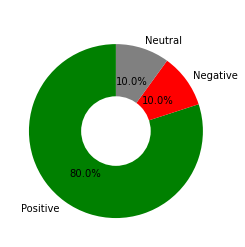

In [119]:
#set three incrementing variables
def_pos_sent_num = 0
def_neu_sent_num = 0
def_neg_sent_num = 0
#iterate over the reviews
for sent in def_ind_rev_list:
    for rev in sent:
        #eval the sentiment of each review and increment the correct variable
        if rev.polarity <= -.25:
            def_neg_sent_num += 1
        elif rev.polarity >= -.24 and rev.polarity <= .25:
            def_neu_sent_num =+ 1
        elif rev.polarity >= .26:
            def_pos_sent_num += 1
#calc the percentages in a list
percentages = [(def_pos_sent_num/8)*100, (def_neg_sent_num/8)*100, (def_neu_sent_num/8)*100]

#initialize the labels and colors for the labels
labels = ['Positive', 'Negative', 'Neutral']
colors = ['green', 'red', 'gray']
#create a pie chart
plt.pie(percentages, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
#draw a white circle in the middle to create a donut chart
inner_circle = plt.Circle((0,0), 0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(inner_circle)
#title the graph
plt.title('Default Sentiment Analysis Results', color='white')
#display the chart
plt.show()

donut chart of the pos, neu, and neg reviews (naive bayes)

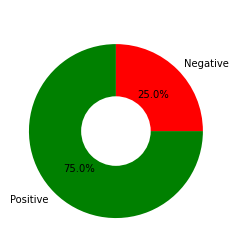

In [120]:
#set three incrementing variables
na_pos_sent_num = 0
na_neg_sent_num = 0
#iterate over the reviews
for sent in na_ind_rev_list:
    for rev in sent:
        #eval the sentiment of each review and increment the correct variable
        if rev.classification == 'neg':
            na_neg_sent_num += 1
        elif rev.classification == 'pos':
            na_pos_sent_num += 1
#calc the percentages in a list
percentages = [(na_pos_sent_num/8)*100, (na_neg_sent_num/8)*100]

#initialize the labels and colors for the labels
labels = ['Positive', 'Negative']
colors = ['green', 'red']
#create a pie chart
plt.pie(percentages, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
#draw a white circle in the middle to create a donut chart
inner_circle = plt.Circle((0,0), 0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(inner_circle)
#title the graph
plt.title('NA Sentiment Analysis Results', color='white')
#display the chart
plt.show()

5
1


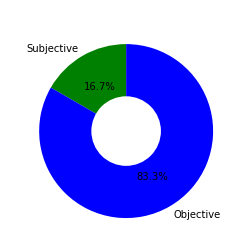

In [136]:
#set two incrementing variables
obj_num = 0
sub_num = 0
#iterate over the reviews
for sent in def_ind_rev_list:
    for rev in sent:
        #eval the sentiment of each review and increment the correct variable
        if rev.subjectivity <= .55:
            obj_num += 1
        elif rev.subjectivity >= .56:
            sub_num =+ 1

#calc the percentages in a list
percentages = [(sub_num/8)*100, (obj_num/8)*100]

#initialize the labels and colors for the labels
labels = ['Subjective', 'Objective']
colors = ['green', 'blue']
#create a pie chart
plt.pie(percentages, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
#draw a white circle in the middle to create a donut chart
inner_circle = plt.Circle((0,0), 0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(inner_circle)
#title the graph
plt.title('Subjectivity Sentiment Analysis Results', color='white')
#display the chart
plt.show()

ratings analysis and chart

get the highest rated bakery

In [130]:
#create variable to hold the highest rated bakery
highest_rat_bakery = ''
#initialize the highhest rating variable
highest_rating = 0
#get the bakery with the highest average rating
for val in business_ratings:
    if sum(business_ratings[val]) > highest_rating:
        highest_rat_bakery = val
        highest_rating = sum(business_ratings[val])

#get the average of the rating
highest_rating = highest_rating/3
#print the results
print(highest_rat_bakery)
print(highest_rating)

Teixeira's Bakery
5.0


get the lowest rated bakery

In [134]:
#create variable to hold the lowest rated bakery
lowest_rat_bakery = ''
#initialize the lowest rating variable
lowest_rating = 20
#get the bakery with the lowest average rating
for val in business_ratings:
    if sum(business_ratings[val]) < lowest_rating:
        lowest_rat_bakery = val
        lowest_rating = sum(business_ratings[val])

#get the average of the rating
lowest_rating = lowest_rating/3
#print the results
print(lowest_rat_bakery)
print(lowest_rating)

Soul Sweet Boutique
2.3333333333333335
